Submitted by:
Maham Waseem (27257)


# Afinity Propogation

Importing the required dependencies

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions
</br>
1-LoadData </br>
2-CleanFun </br>
3-KYFS </br>
4-FTRsclt </br>
5-PCAViz </br>
6-ClusterFun </br>
7-VizFun </br>

1. LoadData

In [2]:
import chardet
import pandas as pd

def LoadData(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



Noise Removal Function

In [3]:
import pandas as pd

def remove_outliers_iqr(data):
    # Copy the data to avoid modifying the original data
    clean_data = data.copy()

    # Loop through each column in the data
    for column in clean_data.select_dtypes(include=['float64', 'int64']).columns:  # Only numeric columns
        Q1 = clean_data[column].quantile(0.25)  # 1st quartile
        Q3 = clean_data[column].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile Range

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the data to remove outliers
        clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]

    return clean_data


2. CleanFun

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def CleanData(df):
    """
    Generalized function to clean a dataset with categorical, integer, binary, continuous, and boolean data types.
    - Automatically handles missing values, encodes categorical data, and scales continuous and integer data.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - df_cleaned: The cleaned and transformed DataFrame.
    """
    # Step 1: Handle special missing value representations ("?" in this dataset)
    df.replace('?', np.nan, inplace=True)

    # Step 2: Detect column types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Detect binary columns (those with exactly 2 unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Detect boolean columns
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers (0 and 1)
    df[boolean_cols] = df[boolean_cols].astype(int)

    # Remove binary and boolean columns from integer cols since they are handled separately
    integer_cols = [col for col in integer_cols if col not in binary_cols + boolean_cols]

    # Step 3: Handle missing values
    # Fill missing continuous values with the mean
    if continuous_cols:
        imputer_cont = SimpleImputer(strategy='mean')
        df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])

    # Fill missing integer values with the median
    if integer_cols:
        imputer_int = SimpleImputer(strategy='median')
        df[integer_cols] = imputer_int.fit_transform(df[integer_cols])

    # Fill missing categorical values with the most frequent value (mode)
    if categorical_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

    # Fill missing binary values with the mode
    if binary_cols:
        imputer_bin = SimpleImputer(strategy='most_frequent')
        df[binary_cols] = imputer_bin.fit_transform(df[binary_cols])

    # Step 4: Encode categorical variables (One-hot encoding)
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Step 5: Scale continuous and integer variables
    scaler = StandardScaler()
    if continuous_cols:
        df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])
    if integer_cols:
        df_encoded[integer_cols] = scaler.fit_transform(df_encoded[integer_cols])

    return df_encoded



In [5]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)


def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df



def CleanFun(data): #This function will clean the dataset.

    print("Number of missing values in your data set:",list_columns_with_missing_values(data))

    print("Number of duplicate rows in your data set:",data.duplicated().sum())
    print("All the missing values have been filled wtih mean values")
    print("All the duplicate rows have been deleted from data set")


    data.drop_duplicates(inplace=True)
    data = fill_null_mean(data)
    return(data)




3. KYFS

In [6]:
def KYFS(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc;

In [7]:
def ViewColumnTypes(df):
    """
    View which columns are categorical, continuous, integer, and binary.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - A dictionary containing column names categorized by type.
    """
    # Step 1: Get columns by data types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Step 2: Identify binary columns (those with exactly two unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Print the results
    print(f"Categorical Columns: {categorical_cols}")
    print(f"Continuous Columns: {continuous_cols}")
    print(f"Integer Columns: {integer_cols}")
    print(f"Binary Columns: {binary_cols}")

    # Return the results in a dictionary (for potential future use)
    return {
        "categorical_cols": categorical_cols,
        "continuous_cols": continuous_cols,
        "integer_cols": integer_cols,
        "binary_cols": binary_cols
    }


4. FTRsclt

In [8]:
def FtrSlct(df, hist_color='MAROON', boxplot_color='MAROON'):
    # Separating numerical and categorical features
    numeric_features = df.select_dtypes(include=['float64','int64','int32'])
    categorical_features = df.select_dtypes(include=['object', 'int64'])

    # Summary statistics
    summary_stats = numeric_features.describe().style.set_properties(**{'color': 'maroon', 'text-align': 'center', 'font-weight': 'bold'})
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)


    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Calculate number of rows needed

    # Histograms and Box plots
    fig, axes = plt.subplots(nrows=num_rows*2, ncols=3, figsize=(16, 5*num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3
        col = i % 3

        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row*2, col])
        axes[row*2, col].set_title(f'Histogram of {column}')
        axes[row*2, col].set_xlabel(column)
        axes[row*2, col].set_ylabel('Frequency')

        sns.boxplot(data=df, y=column, color=boxplot_color, ax=axes[row*2+1, col])
        axes[row*2+1, col].set_title(f'Boxplot of {column}')
        axes[row*2+1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Calculate correlation matrix
    correlation_matrix = numeric_features.corr()

    # Correlation matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap of 30 Variables')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()



Normalization

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to normalize data and show new ranges
def normalize_data(dataframe):
    # Ensure the dataframe is a pandas DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame.")

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply Min-Max scaling to all columns (assuming numerical data)
    normalized_data = scaler.fit_transform(dataframe)

    # Create a DataFrame with normalized values
    normalized_df = pd.DataFrame(normalized_data, columns=dataframe.columns)

    # Display the new ranges of individual features
    new_ranges = normalized_df.min(), normalized_df.max()
    print("New Ranges of the Features:")
    for feature, (min_val, max_val) in zip(normalized_df.columns, zip(new_ranges[0], new_ranges[1])):
        print(f"{feature}: Min = {min_val}, Max = {max_val}")

    return normalized_df


Grid Search with TSNE

In [33]:
import numpy as np
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def tsne_perform_clustering_and_plot(data):
    # Define parameter grid for Affinity Propagation
    preference_values = np.linspace(-100,-80,3)  # Example range for `preference`
    damping_values = np.linspace(0.8, 0.95, 3)  # Example range for `damping`

    # Prepare a list to store results
    results_affinity = []

    # Affinity Propagation Grid Search
    for preference in preference_values:
        for damping in damping_values:
            ap = AffinityPropagation(preference=preference, damping=damping, random_state=42)
            ap_labels = ap.fit_predict(data)
            n_clusters_ap = len(set(ap_labels)) - (1 if -1 in ap_labels else 0)
            results_affinity.append([preference, damping, n_clusters_ap])

    # Convert results to DataFrame
    df_affinity = pd.DataFrame(results_affinity, columns=['preference', 'damping', 'n_clusters'])

    # Select top models for visualization
    df_affinity_sorted = df_affinity.sort_values(by=['n_clusters'], ascending=False).head(3)

    best_affinity_models = []

    # Instantiate best Affinity Propagation models
    for i in range(3):
        best_affinity = AffinityPropagation(
            preference=df_affinity_sorted.iloc[i]['preference'],
            damping=df_affinity_sorted.iloc[i]['damping'],
            random_state=42
        )
        best_affinity_models.append(best_affinity)

    # Reduce data to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)

    # Plot results
    plt.figure(figsize=(15, 12))
    plt.suptitle("TSNE Plot with Affinity Propagation Clustering", fontsize=16)  # Main heading for the entire plot

    # Affinity Propagation Visualization
    for i, ap_model in enumerate(best_affinity_models):
        ap_labels = ap_model.fit_predict(data)
        n_clusters_ap = len(set(ap_labels)) - (1 if -1 in ap_labels else 0)

        plt.subplot(3, 2, i * 2 + 1)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=ap_labels, cmap='viridis')
        plt.title(f'Affinity Propagation (pref={ap_model.preference:.2f}, damp={ap_model.damping:.2f}, clusters={n_clusters_ap})')
        plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


PCA Visualization

In [35]:
import numpy as np
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def perform_clustering_and_plot(data, preference, damping):
    """
    Perform Affinity Propagation clustering and visualize results using PCA.

    Parameters:
    - data: Input data for clustering (array-like).
    - preference: Preference parameter for Affinity Propagation.
    - damping: Damping factor for Affinity Propagation.
    """
    # Affinity Propagation Clustering
    ap = AffinityPropagation(preference=preference, damping=damping, random_state=42)
    ap_labels = ap.fit_predict(data)
    n_clusters_ap = len(set(ap_labels))
    noise_points_ap = np.sum(ap_labels == -1)  # Affinity Propagation does not label noise points explicitly

    # Reduce data to 2D for visualization using PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    # Plot results
    plt.figure(figsize=(10, 8))

    # Affinity Propagation Visualization
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=ap_labels, cmap='viridis', s=50)
    plt.title(f'Affinity Propagation (preference={preference}, damping={damping}, clusters={n_clusters_ap})')
    plt.colorbar(label='Cluster Labels')

    # Add a main title for the entire plot
    plt.suptitle('Affinity Propagation Clustering with PCA', fontsize=16)

    plt.tight_layout()
    plt.show()


In [ ]:
#Cluster Visualization in High Dimensionality to check all the features working in every single clusters

In [ ]:
#Heatmap Function

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import MinMaxScaler

def HeatmapFeatureMeansWithClustering(df, preference, damping, show_affinity=True):
    """
    Plot side-by-side heatmaps showing the normalized mean values of original features
    for each cluster using Affinity Propagation clustering method after Min-Max scaling.

    Parameters:
    - df: DataFrame with original features.
    - preference: Preference parameter for Affinity Propagation.
    - damping: Damping factor for Affinity Propagation.
    - show_affinity: Boolean flag to show Affinity Propagation clustering results (default is True).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform Affinity Propagation clustering
    ap = AffinityPropagation(preference=preference, damping=damping, random_state=42)
    ap_labels = ap.fit_predict(df_scaled)

    # Function to plot the heatmap for Affinity Propagation clustering
    def plot_heatmap(data, labels, title, ax):
        # Assign clusters and calculate mean feature values for each cluster
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Plot heatmap of the cluster means
        sns.heatmap(cluster_means, annot=True, cmap="viridis", cbar=True, ax=ax)
        ax.set_title(title, size=15)
        ax.set_xlabel("Features")
        ax.set_ylabel("Clusters")

    # Create a plot for Affinity Propagation clustering heatmap
    fig, ax = plt.subplots(figsize=(8, 8))

    if show_affinity:
        plot_heatmap(df_scaled.copy(), ap_labels, f'Affinity Propagation (preference={preference}, damping={damping})', ax)
    else:
        ax.axis('off')  # If not showing Affinity Propagation, hide the plot

    plt.tight_layout()  # Adjust layout to give some padding
    plt.show()


In [ ]:
#Radial Plot Visualization

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import MinMaxScaler

def RadialFeatureMeansWithClustering(df, preference=-50, damping=0.5, show_affinity=True):
    """
    Plot radial charts showing the normalized mean values of original features
    for each cluster using Affinity Propagation clustering method after Min-Max scaling.

    Parameters:
    - df: DataFrame with original features.
    - preference: Preference parameter for Affinity Propagation (default is -50).
    - damping: Damping factor for Affinity Propagation (default is 0.5).
    - show_affinity: Boolean flag to show Affinity Propagation clustering results (default is True).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform Affinity Propagation clustering
    affinity = AffinityPropagation(preference=preference, damping=damping, random_state=42)
    affinity_labels = affinity.fit_predict(df_scaled)

    # Helper function to plot radial chart for Affinity Propagation clustering
    def plot_radial_chart(data, labels, title, ax):
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean().reset_index()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Create radial chart for each cluster
        categories = list(cluster_means.columns[1:])  # Skip 'Cluster' column
        num_vars = len(categories)

        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the loop for the radial plot

        for i, row in cluster_means.iterrows():
            values = row[1:].tolist()  # Get values for each feature
            values += values[:1]  # Close the loop

            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {int(row["Cluster"])}')
            ax.fill(angles, values, alpha=0.25)

        ax.set_title(title, size=15)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_yticklabels([])

    # Create radial plot for Affinity Propagation clustering
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(polar=True))

    if show_affinity:
        plot_radial_chart(df_scaled.copy(), affinity_labels, f'Affinity Propagation (preference={preference}, damping={damping})', ax)
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # Add legend for Affinity Propagation clusters
    else:
        ax.axis('off')  # If not showing Affinity Propagation, hide the plot

    plt.tight_layout()  # Adjust layout to give some padding
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame with original features
# RadialFeatureMeansWithClustering(df, preference=-50, damping=0.5, show_affinity=True)


Master Function

In [11]:
data=LoadData(r'/content/customer_segmentation.csv')

In [12]:
data = data.drop(columns=['ID','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Complain','Z_CostContact','Z_Revenue'])

In [13]:
# encoded_data = CleanData(data)

In [14]:
data=CleanFun(data)

Number of missing values in your data set: Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
dtype: int64
Number of duplicate rows in your data set: 201
All the missing values have been filled wtih mean values
All the duplicate rows have been deleted from data set


In [15]:
KYFS(data)

,type,count,nunique,%unique,null,%null,min,max
Year_Birth,int64,2039,59,2.893575,0,0.0,1893,1996
Education,object,2039,5,0.245218,0,0.0,2n Cycle,PhD
Marital_Status,object,2039,8,0.392349,0,0.0,Absurd,YOLO
Income,float64,2039,1975,96.861206,0,0.0,1730.0,666666.0
Kidhome,int64,2039,3,0.147131,0,0.0,0,2
Teenhome,int64,2039,3,0.147131,0,0.0,0,2
Dt_Customer,object,2039,663,32.515939,0,0.0,1/1/2013,9/9/2013
Recency,int64,2039,100,4.904365,0,0.0,0,99
MntWines,int64,2039,776,38.057872,0,0.0,0,1493
MntFruits,int64,2039,158,7.748897,0,0.0,0,199


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Convert categorical columns to numeric
data['Education'] = label_encoder.fit_transform(data['Education'])  # Encode education
data['Marital_Status'] = label_encoder.fit_transform(data['Marital_Status'])  # Encode marital status
data['Dt_Customer'] = label_encoder.fit_transform(data['Dt_Customer'])  # Encode customer date


In [17]:

# List of features to convert to float
features_to_convert = [
'Year_Birth', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
]

# Convert specified columns to float
data[features_to_convert] = data[features_to_convert].astype(float)

View types for each feature

In [18]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1957.0,2.0,4.0,58138.0,0.0,0.0,553.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0
1,1954.0,2.0,4.0,46344.0,1.0,1.0,629.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0
2,1965.0,2.0,5.0,71613.0,0.0,0.0,293.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0
3,1984.0,2.0,5.0,26646.0,1.0,0.0,31.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0
4,1981.0,4.0,3.0,58293.0,1.0,0.0,216.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0


In [19]:
original_data = data
data2 = data

The data is now cleaned

In [20]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1957.0,2.0,4.0,58138.0,0.0,0.0,553.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0
1,1954.0,2.0,4.0,46344.0,1.0,1.0,629.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0
2,1965.0,2.0,5.0,71613.0,0.0,0.0,293.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0
3,1984.0,2.0,5.0,26646.0,1.0,0.0,31.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0
4,1981.0,4.0,3.0,58293.0,1.0,0.0,216.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0



Summary Statistics:


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,1968.768024,2.392349,3.719961,52362.016377,0.444826,0.507602,326.142227,49.096616,303.332026,26.351153,167.755272,37.456596,27.215792,43.760177,2.329083,4.098578,2.658656,5.772437,5.310446
std,11.983086,1.126041,1.072700,25429.606626,0.537843,0.546930,192.317204,28.974507,335.823263,39.824028,227.930430,54.704882,41.701678,52.024687,1.934170,2.799936,2.936390,3.236841,2.438496
min,1893.000000,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,2.000000,3.000000,35702.500000,0.000000,0.000000,163.500000,24.000000,23.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,1970.000000,2.000000,4.000000,52074.000000,0.000000,0.000000,322.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,1977.000000,3.000000,5.000000,68298.500000,1.000000,1.000000,494.000000,74.000000,503.500000,33.000000,230.000000,50.000000,34.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,1996.000000,4.000000,7.000000,666666.000000,2.000000,2.000000,662.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


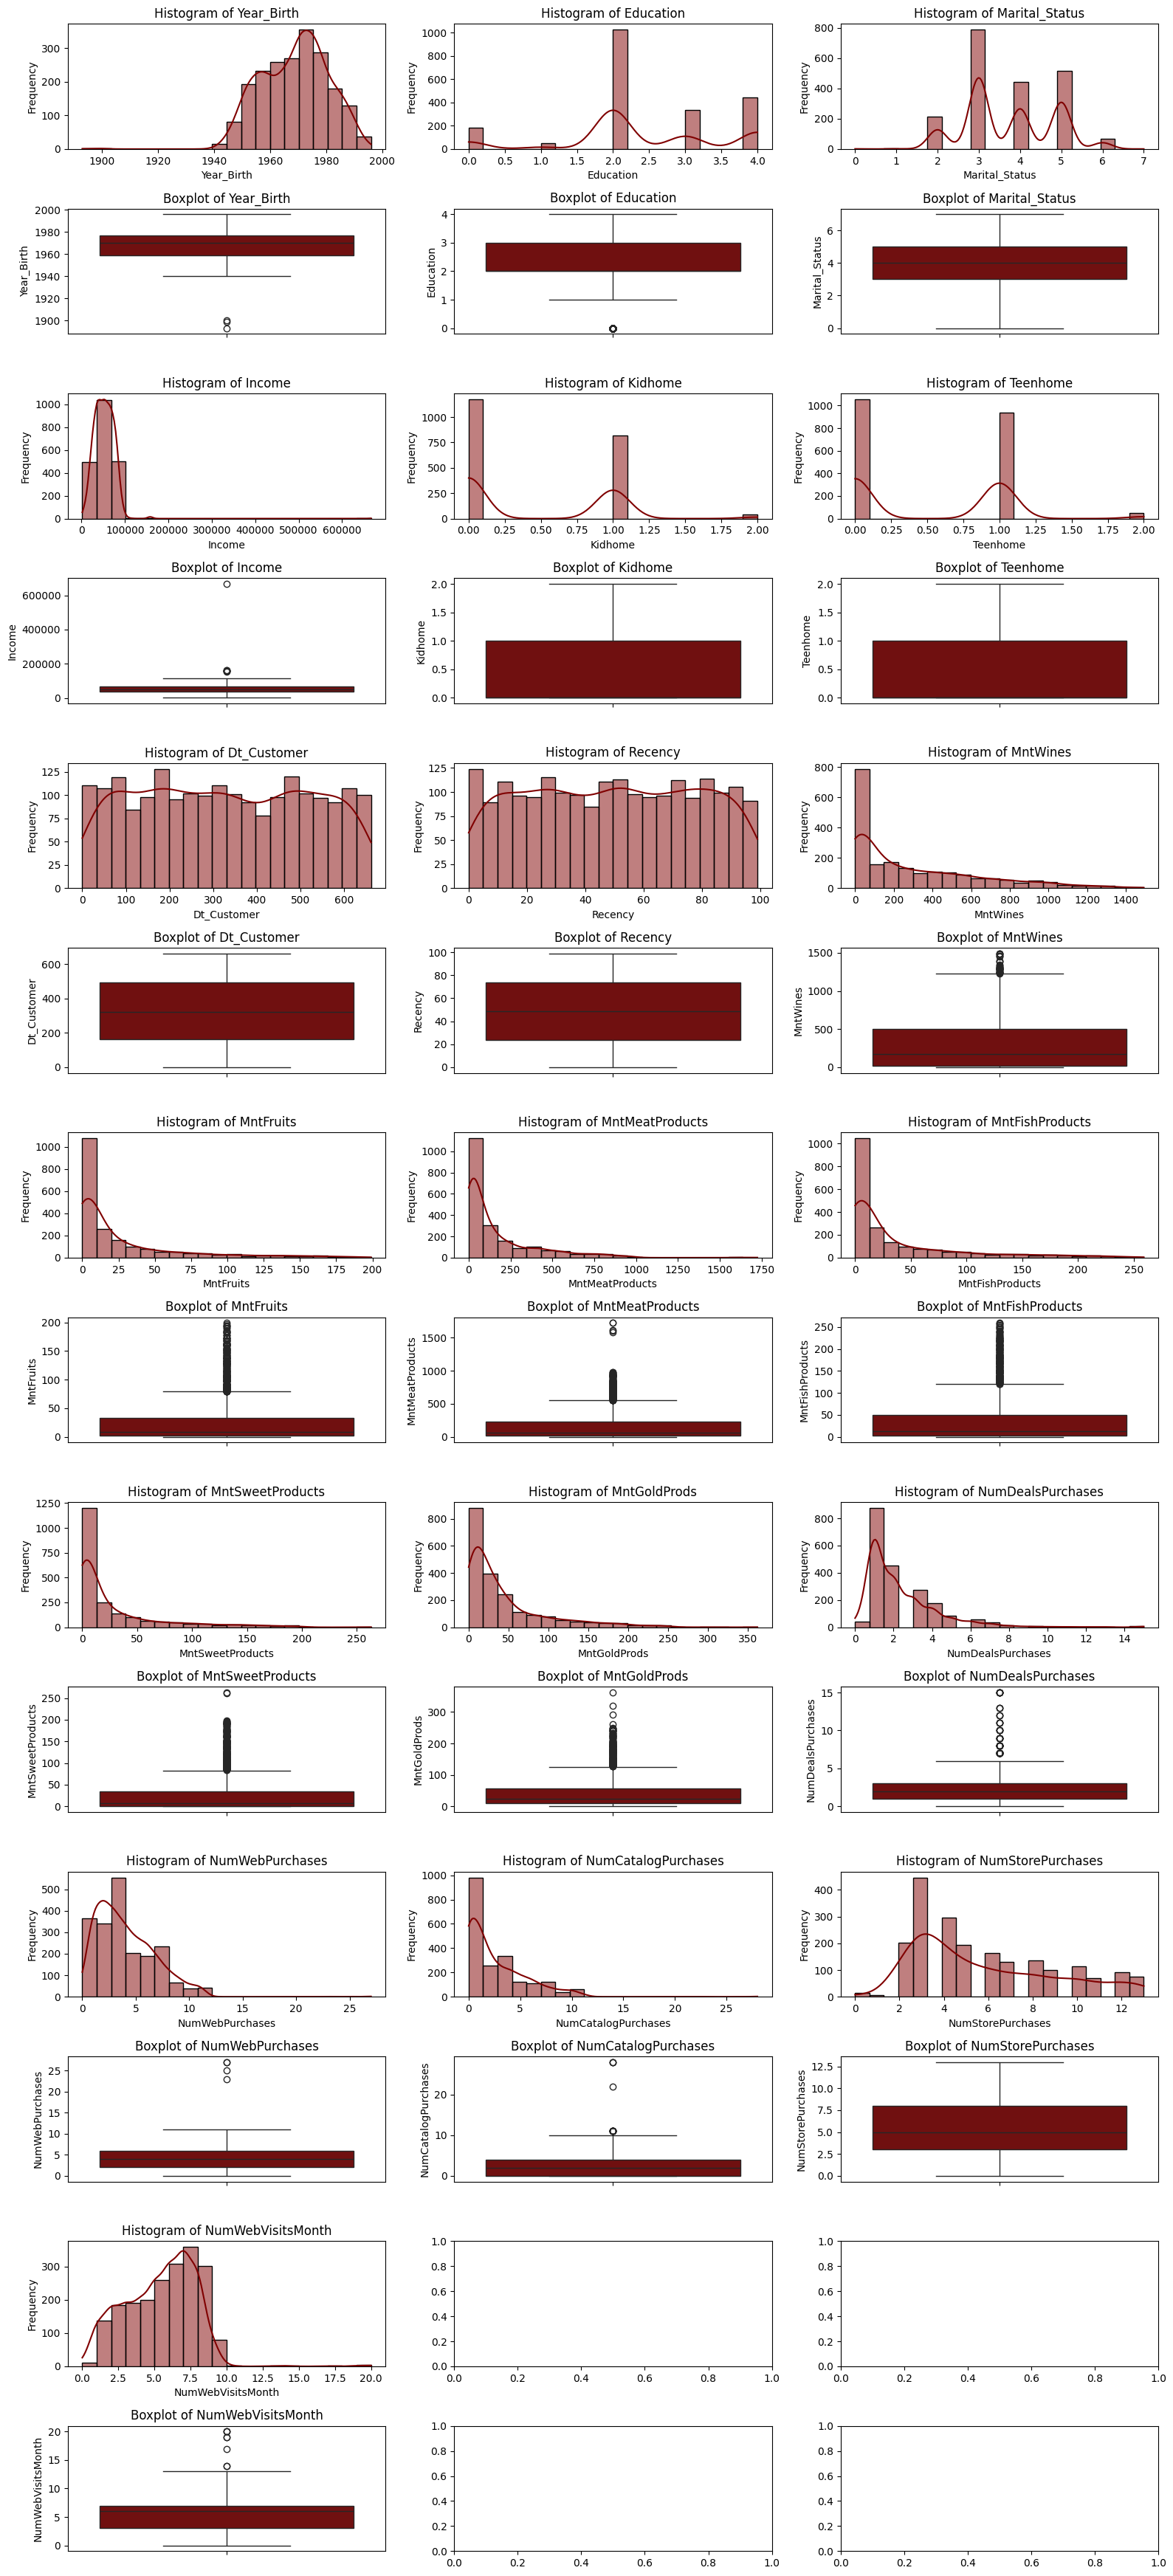

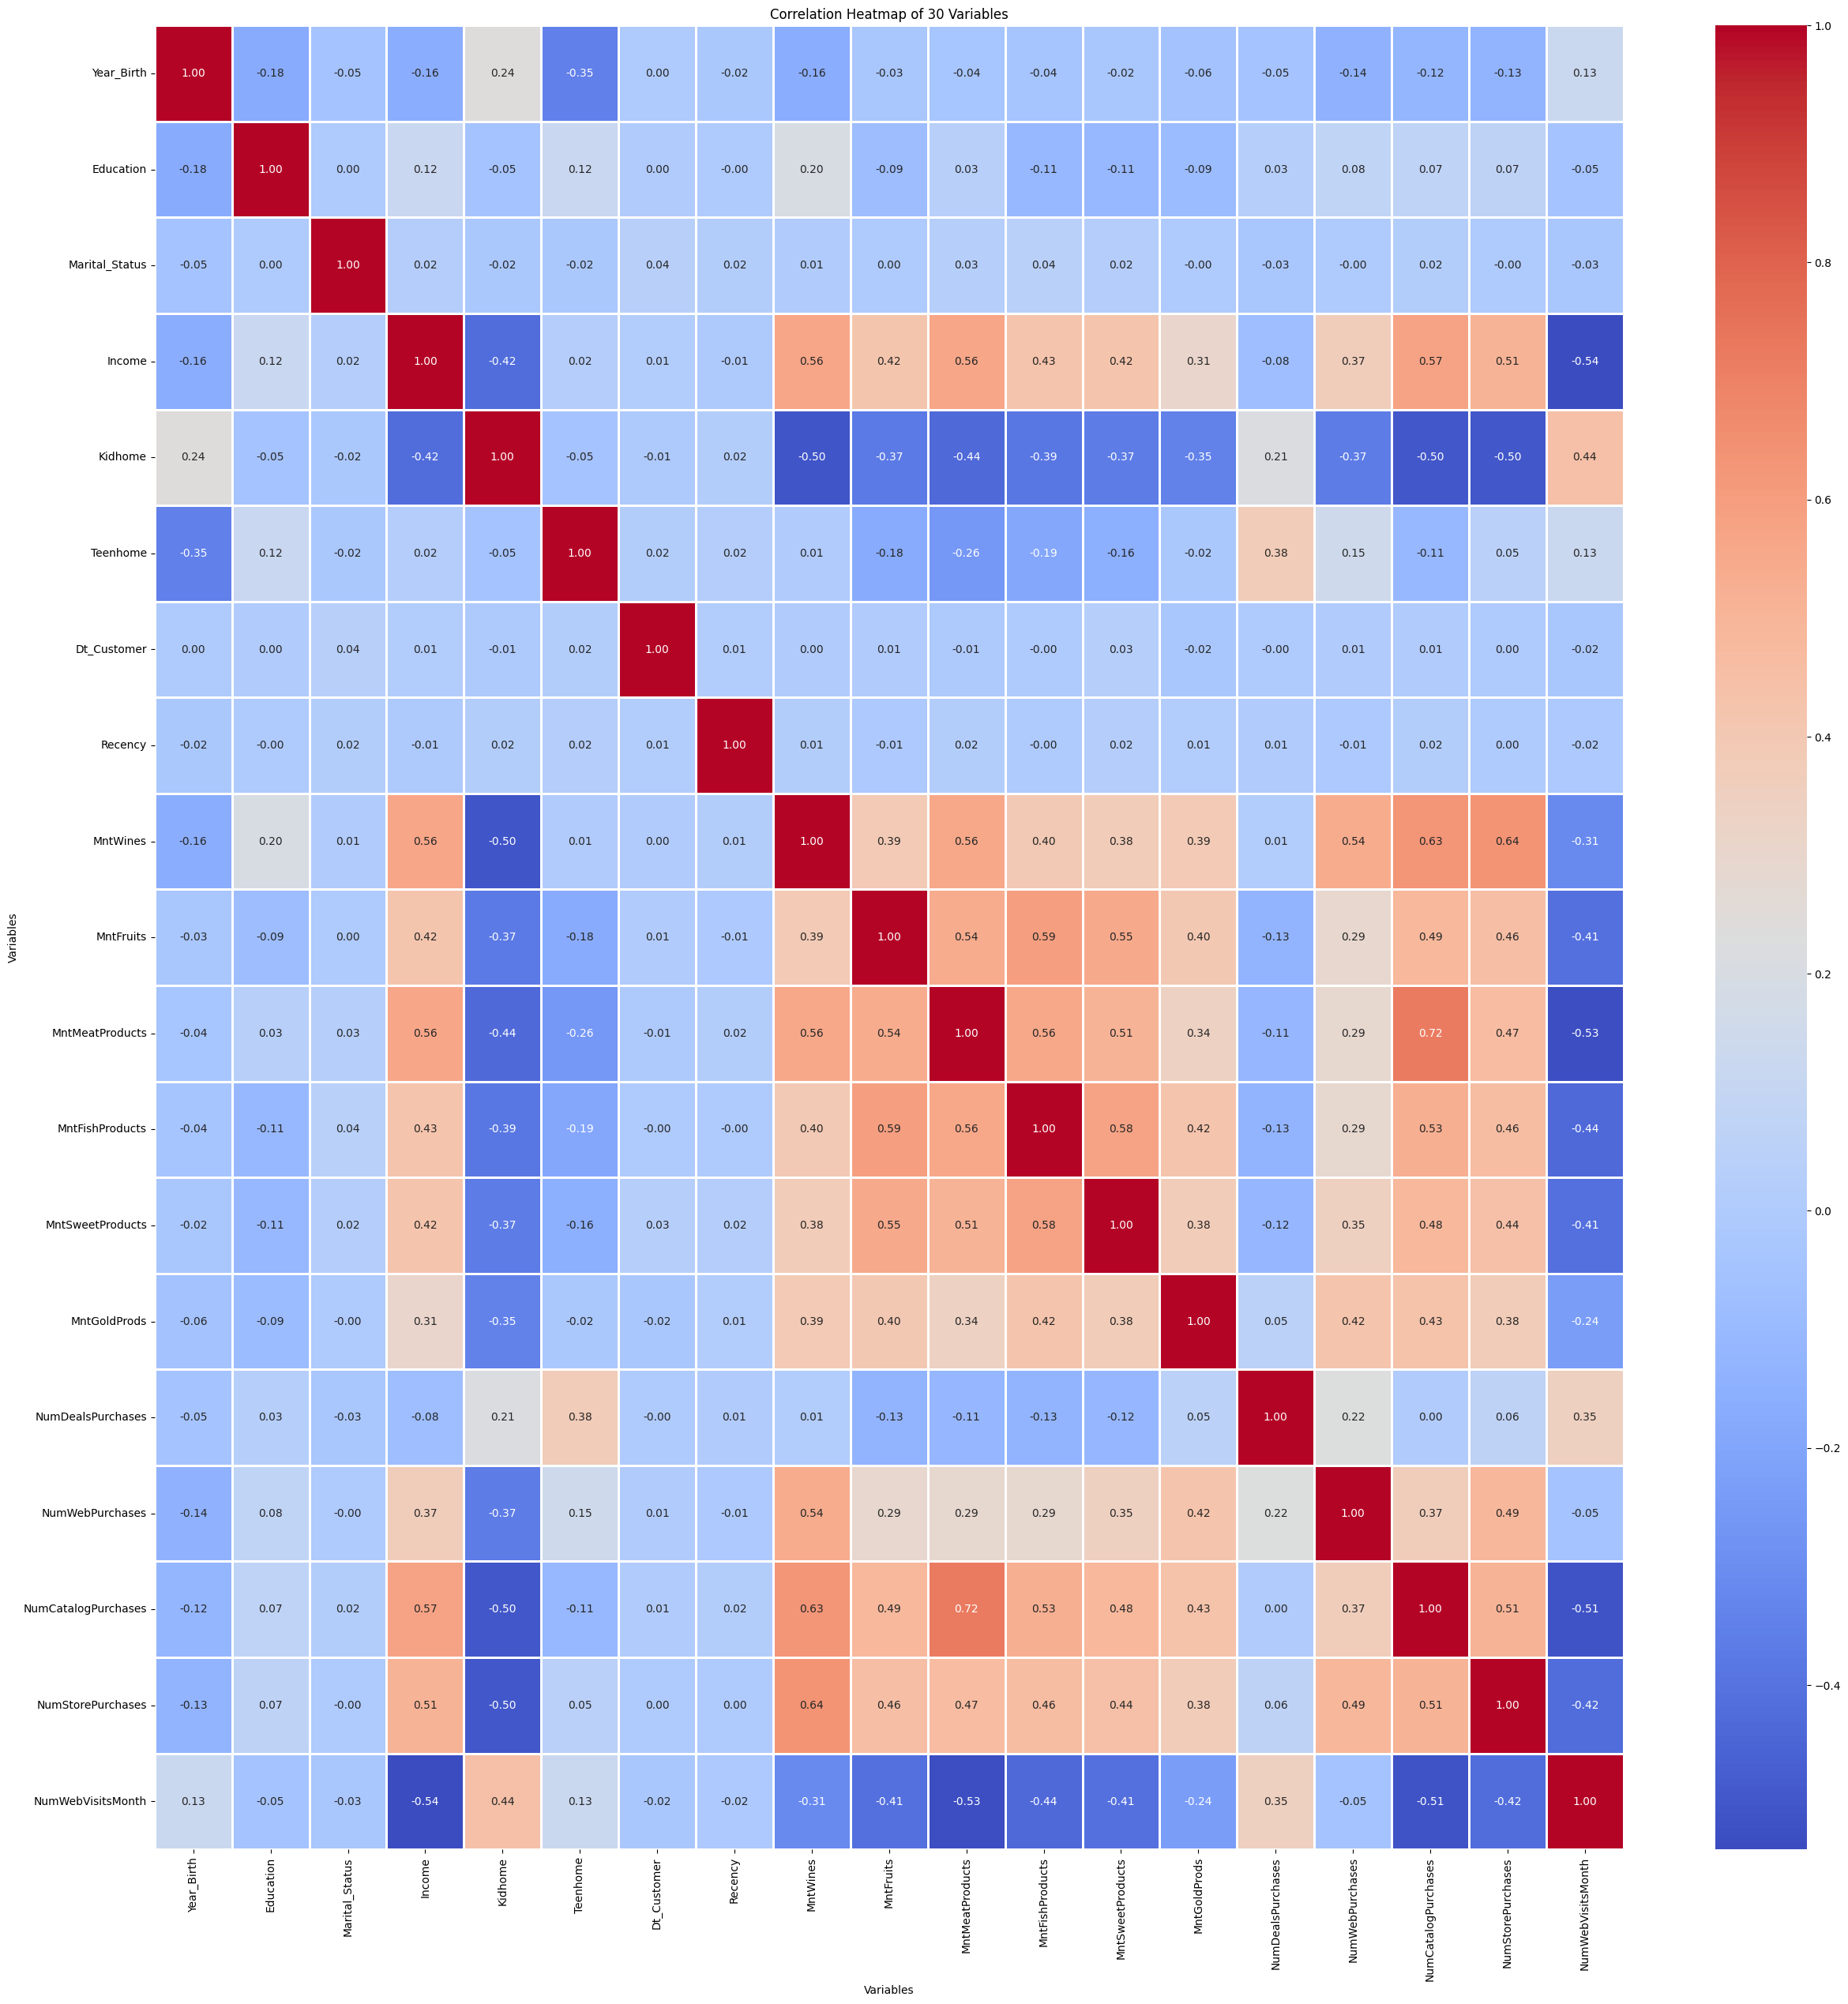

In [ ]:
FtrSlct(data);

In [21]:
import pandas as pd
import numpy as np

def drop_highly_correlated(data, threshold=0.8):
    """
    Drop columns from a DataFrame based on high correlation between columns.

    Parameters:
    - df: DataFrame
    - threshold: Correlation threshold to identify highly correlated columns (default=0.8)

    Returns:
    - DataFrame with highly correlated columns removed
    """
    # Step 1: Calculate the correlation matrix
    corr_matrix = data.corr().abs()

    # Step 2: Identify columns to drop (those with correlations above the threshold)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Step 3: Find index of columns with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Columns to drop: {to_drop}")

    # Step 4: Drop the highly correlated columns
    df_reduced = data.drop(columns=to_drop)

    return df_reduced

# Example usage:
correlated_columns = drop_highly_correlated(data, threshold=0.39)


Columns to drop: ['Kidhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']


In [22]:
data= data.drop(columns=['Kidhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'])


In [23]:
data = remove_outliers_iqr(data)


In [24]:
data

,Year_Birth,Education,Marital_Status,Income,Teenhome,Dt_Customer,Recency,NumDealsPurchases
0,1957.0,2.0,4.0,58138.0,0.0,553.0,58.0,3.0
1,1954.0,2.0,4.0,46344.0,1.0,629.0,38.0,2.0
2,1965.0,2.0,5.0,71613.0,0.0,293.0,26.0,1.0
3,1984.0,2.0,5.0,26646.0,0.0,31.0,26.0,2.0
4,1981.0,4.0,3.0,58293.0,0.0,216.0,94.0,5.0
...,...,...,...,...,...,...,...,...
2232,1986.0,2.0,4.0,26816.0,0.0,183.0,50.0,1.0
2235,1967.0,2.0,3.0,61223.0,1.0,98.0,46.0,2.0
2237,1981.0,2.0,2.0,56981.0,0.0,370.0,91.0,1.0
2238,1956.0,3.0,5.0,69245.0,1.0,349.0,8.0,2.0


In [25]:
# Example usage:
data = normalize_data(data)

New Ranges of the Features:
Year_Birth: Min = 0.0, Max = 1.0
Education: Min = 0.0, Max = 1.0
Marital_Status: Min = 0.0, Max = 1.0
Income: Min = 0.0, Max = 1.0000000000000002
Teenhome: Min = 0.0, Max = 1.0
Dt_Customer: Min = 0.0, Max = 1.0
Recency: Min = 0.0, Max = 1.0
NumDealsPurchases: Min = 0.0, Max = 1.0


In [26]:
data.shape


(1774, 8)

GRID SEARCH WITH TSNE

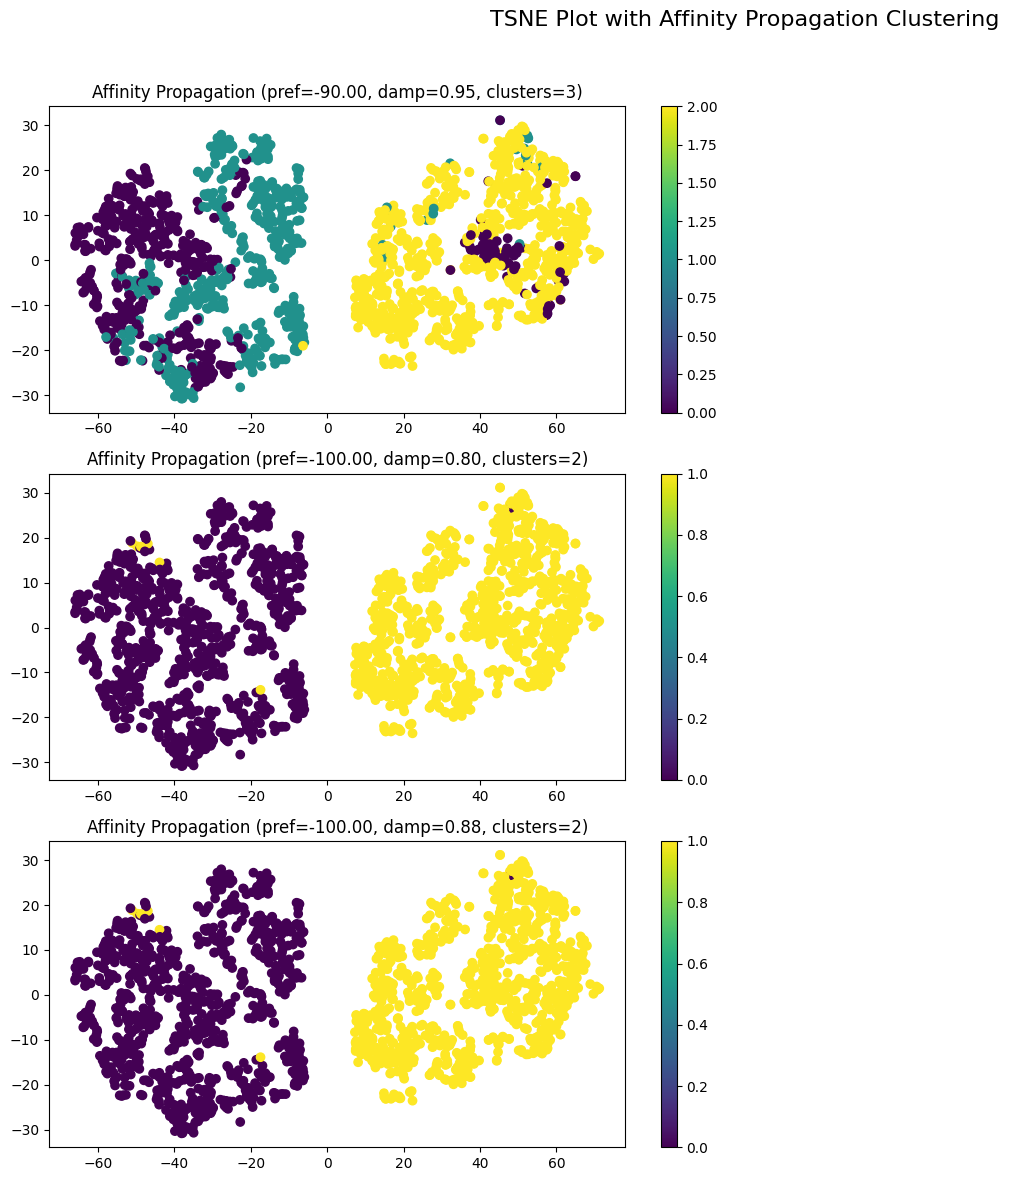

In [34]:
tsne_perform_clustering_and_plot(data)

## As per the business Domain we are choosing the Preference and Damping factor as -100 and 0.88

---



# PCA

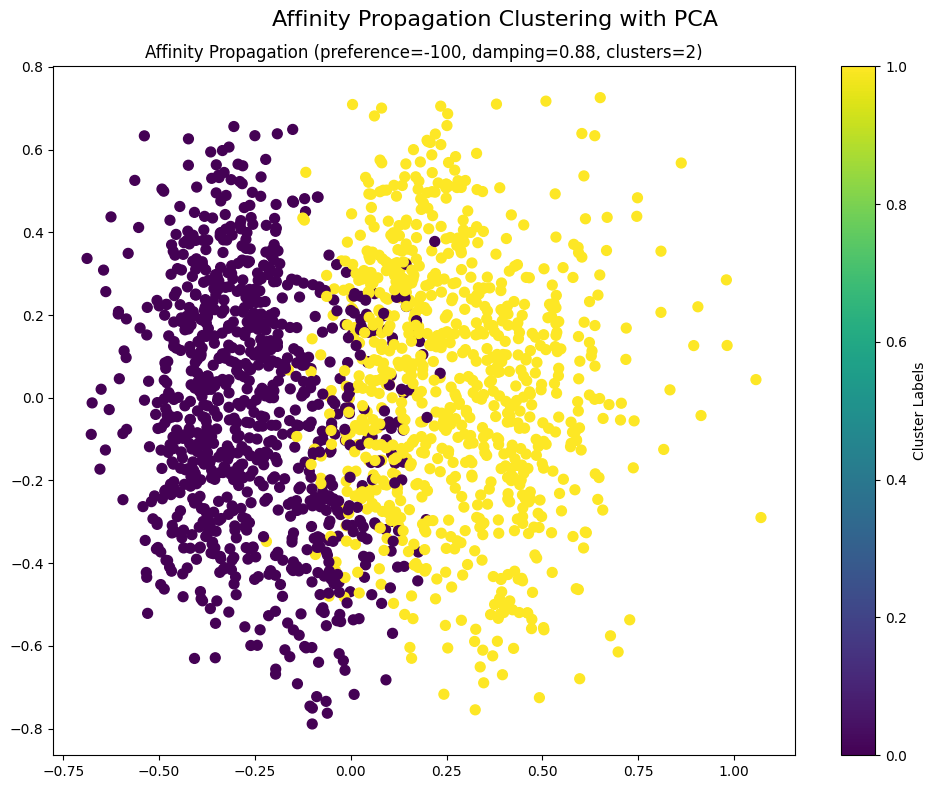

In [36]:
perform_clustering_and_plot(data, preference=-100, damping=0.88)


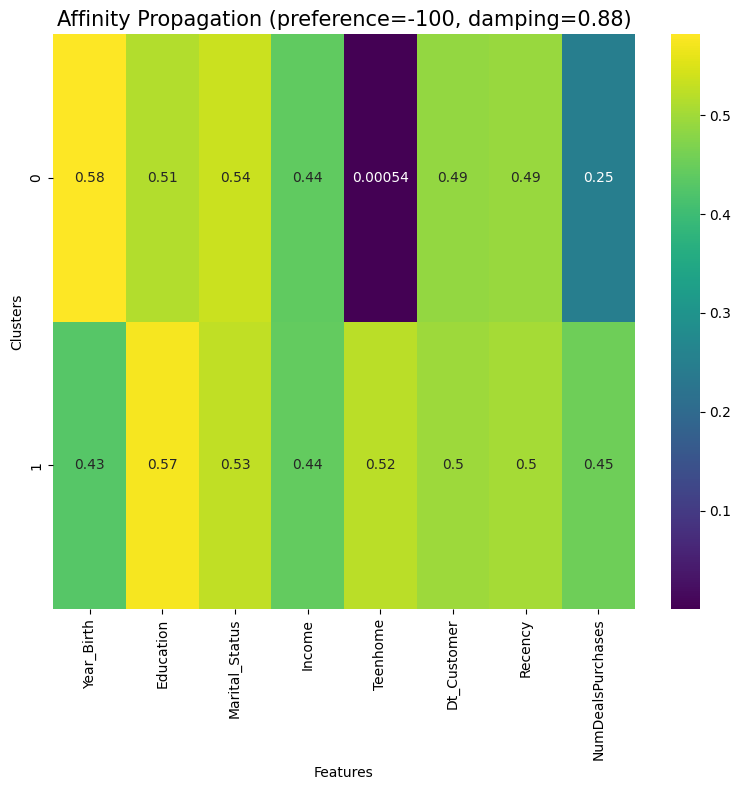

In [38]:
HeatmapFeatureMeansWithClustering(data, preference=-100, damping=0.88)


With the choosen Preferneces two clusters are shown in the above cluster number of deal purchases feature we can we say that the cluster 0 is the clusters of low purchasing customer segmentation. and cluster 1 is high

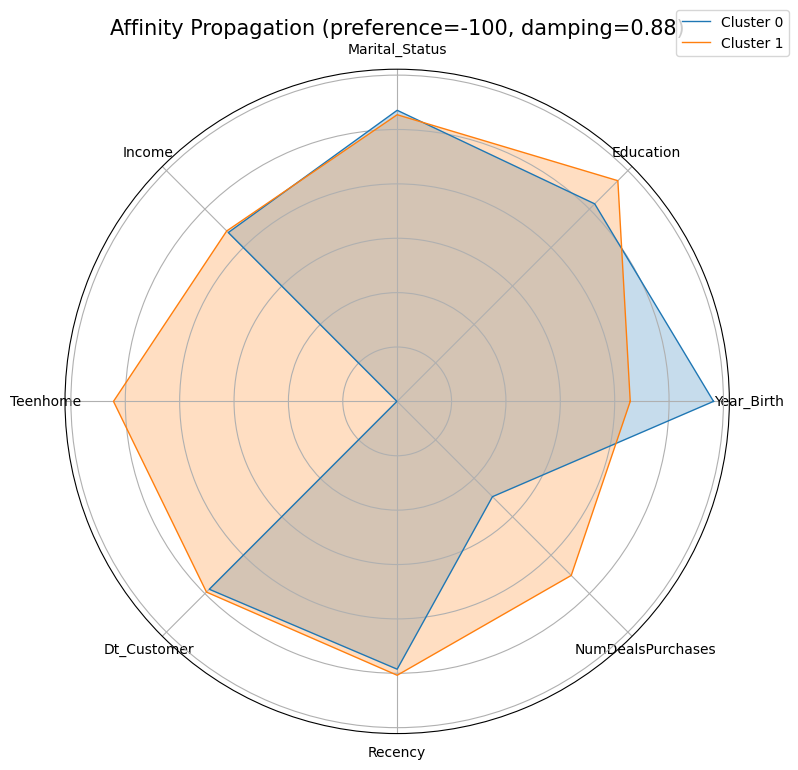

In [41]:
RadialFeatureMeansWithClustering(data, preference=-100, damping=0.88)


With the choosen Preferneces two clusters are shown in the above cluster number of deal purchases feature we can we say that the cluster 0 is the clusters of low purchasing customer segmentation. and cluster 1 is high

# Decreasing Preferences

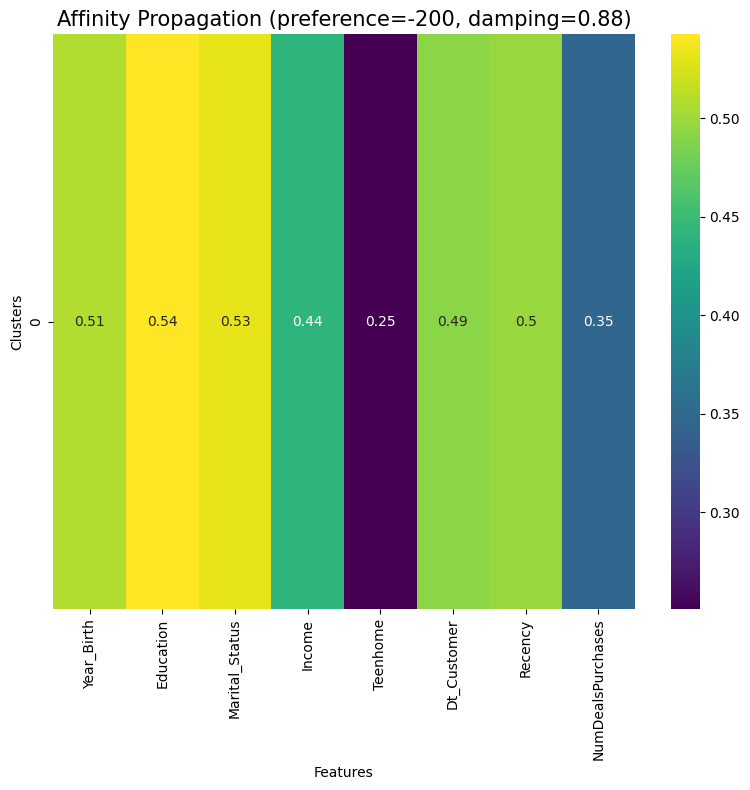

In [53]:
HeatmapFeatureMeansWithClustering(data, preference=-200, damping=0.88)


In [ ]:
No of clusters descreases

# Increasing Preferences

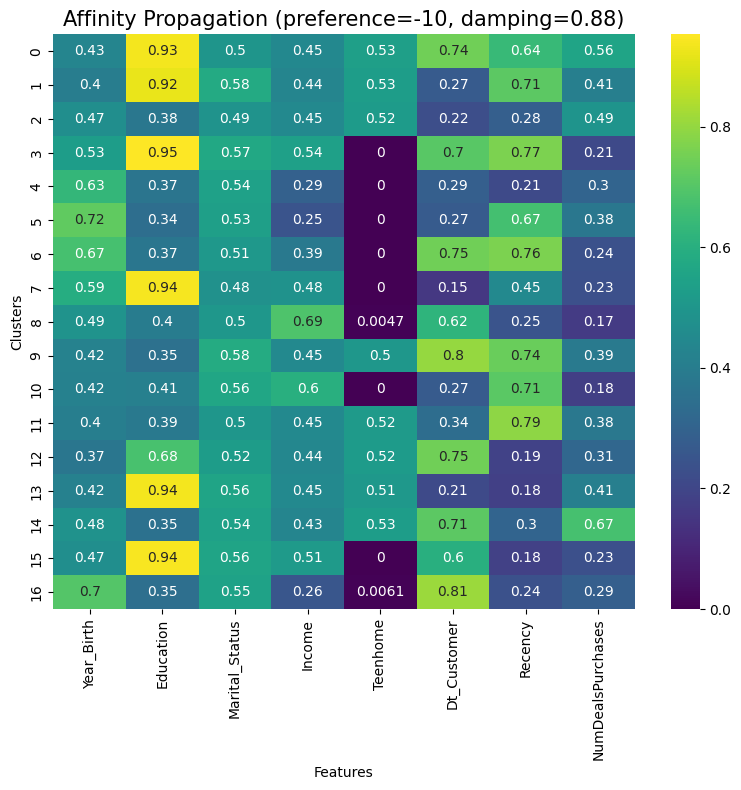

In [54]:
HeatmapFeatureMeansWithClustering(data, preference=-10, damping=0.88)


Number of Clusters increases

Decreasing Damping Factor

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:164: ConvergenceWarning: Affinity propagation did not converge and this model will not have any cluster centers.
  warnings.warn(


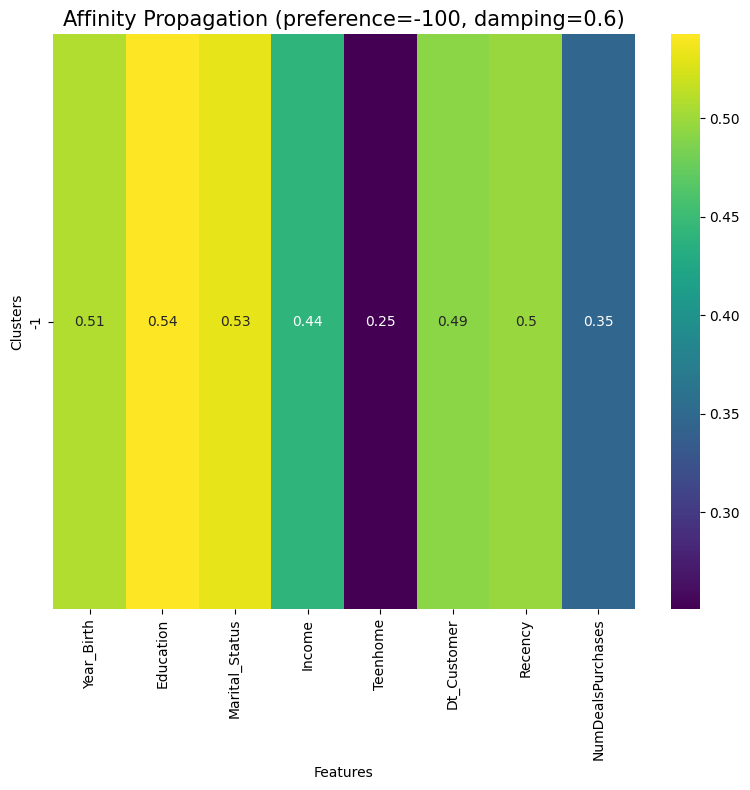

In [55]:
HeatmapFeatureMeansWithClustering(data, preference=-100, damping=0.6)


No of Cluster decreases

Increasing Damping Factor

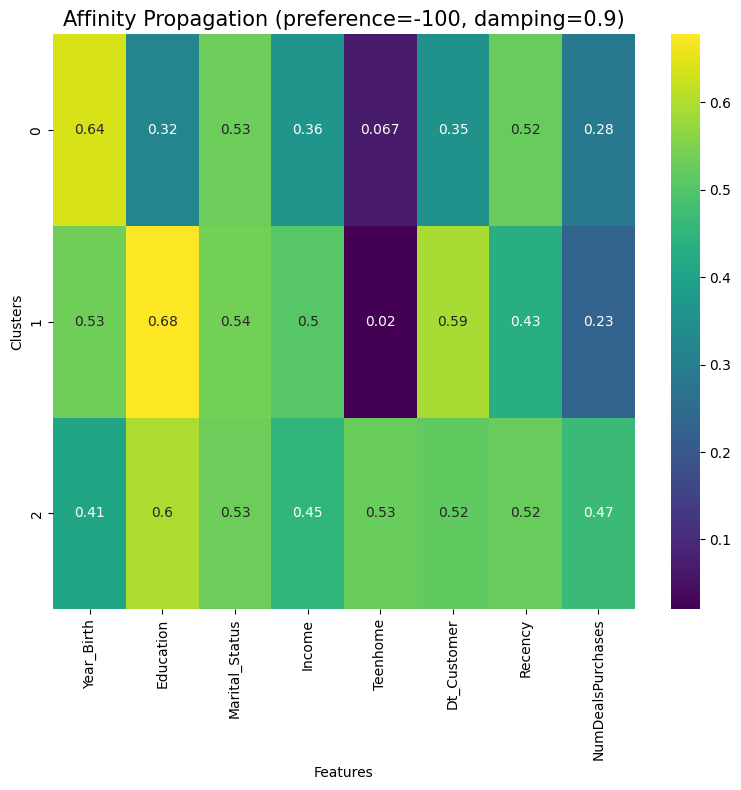

In [58]:
HeatmapFeatureMeansWithClustering(data, preference=-100, damping=0.9)


In [ ]:
No of cluster inceases